<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 7.2.1: Bagging

INSTRUCTIONS:

- Read the guides and hints then create the necessary analysis and code to find an answer and conclusion for the scenario below.
- The baseline results (minimum) are:
    - **Accuracy** = 0.9667
    - **ROC AUC**  = 0.9614
- Try to achieve better results!

# Imports #

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

## Import custom functions from 'regression_functions.py' ##
try:
    import importlib
    importlib.reload(fn)
except NameError: # It hasn't been imported yet
    import supervised_learning_functions as fn
    
sns.set()

# Foreword
It is common that companies and professionals start with the data immediately available. Although this approach works, ideally the first step is to identify the problem or question and only then identify and obtain the set of data that can help to solve or answer the problem.

Also, given the current abundance of data, processing power and some particular machine learning methods, there could be a temptation to use ALL the data available. **Quality** is _**better**_ than **Quantity**!

Part of calling this discipline **Data Science** is that it is supposed to follow a process and not reach conclusions without support from evidence.

Moreover, it is a creative, exploratory, laborious, iterative and interactive process. It is part of the process to repeat, review and change when finding a dead-end.

## Scenario: Predicting Breast Cancer
The dataset you are going to be using for this laboratory is popularly known as the **Wisconsin Breast Cancer** dataset (`breast-cancer-wisconsin-data-old.csv`). The task related to it is Classification.

The dataset contains a total number of _10_ features labelled in either **benign** or **malignant** classes. The features have _699_ instances out of which _16_ feature values are missing. The dataset only contains numeric values.

**So clearly this dataset is using patient data for people that have undergone some breast cancer screening process. Some relevant questions might be:**
1. How accurate are the biomarkers used in predicting malignant and benign tumors (i.e. can we detect malignant tumors, given a set of biomarkers)?
2. Which biomarkers are important in detecting malignant tumors?
3. Are there different clusters of patients based on these biomarkers? How many clusters are there? How does it related to their prediction of malignant vs. benign tumors? For example, if there are more than 2 clusters, is their associated "probability" of having a malignant tumor different?

**Probably a combination of the first 2 questions makes sense to try and answer**

# Find the Data
### Wisconsin Breast Cancer DataSet
- **Citation Request**

    This breast cancer databases was obtained from the **University of Wisconsin Hospitals**, **Madison** from **Dr. William H. Wolberg**. If you publish results when using this database, then please include this information in your acknowledgements.

- **Title**

    Wisconsin Breast Cancer Database (January 8, 1991)

- **Sources**
    - **Creator**
            Dr. William H. Wolberg (physician)
            University of Wisconsin Hospitals
            Madison, Wisconsin
            USA
    - **Donor**
            Olvi Mangasarian (mangasarian@cs.wisc.edu)
            Received by David W. Aha (aha@cs.jhu.edu)
    - **Date**
            15 July 1992
        
### UCI - Machine Learning Repository
- Center for Machine Learning and Intelligent Systems

The [**UCI Machine Learning Repository**](http://archive.ics.uci.edu/ml/about.html) is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

# Read the Data
- Read the data
- Perform some basic structural cleaning to facilitate the work

In [3]:
data = pd.read_csv('breast-cancer-wisconsin-data-old.csv')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample_number                699 non-null    int64 
 1   Clump_Thickness              699 non-null    int64 
 2   Cell_Size_Uniformity         699 non-null    int64 
 3   Cell_Shape_Uniformity        699 non-null    int64 
 4   Marginal_Adhesion            699 non-null    int64 
 5   Single_Epithelial_Cell_Size  699 non-null    int64 
 6   Bare_Nuclei                  699 non-null    object
 7   Bland_Chromatin              699 non-null    int64 
 8   Normal_Nucleoli              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  Class                        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


- It looks like the 'Bare_Nuclei' feature might need some cleaning

In [11]:
data['Bare_Nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

- So they are numeric values in string format, so this needs to be fixed
- The question mark values are presumably null values, so they need to be treated

In [14]:
data['Class'].unique()

array([2, 4], dtype=int64)

- The class labels are 2 and 4, which signify benign and malignant, respectively. Might be good to convert this to binary format (i.e. 0 for benign and 1 for malignant)

# EDA and cleaning #

**1. Treat null-values**

- How many null values are there?

In [17]:
data.value_counts('Bare_Nuclei')

Bare_Nuclei
1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
dtype: int64

- What is the distribution of values for this feature?

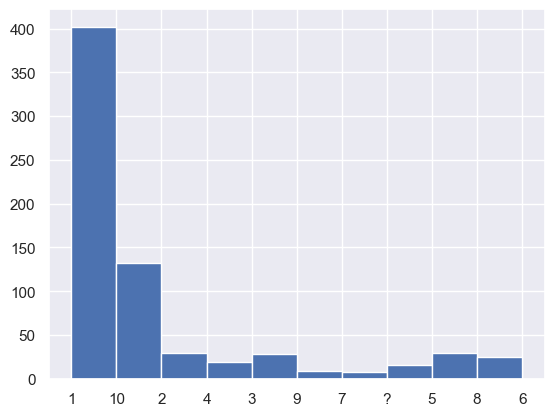

In [20]:
plt.hist(data['Bare_Nuclei']);

- Given the skewed distribution of this feature towards a value of 1 (and to a lesser extent, 10), using the mean to replace null values is probably not a good idea.
- Using the mode would be the easiest replacement method, but maybe there are other methods that replace according to the true distribution of the non-null values.
- **For now, since there are only 16 null-values out of 699 samples, it is probably okay to drop these null values. But first, we should check if these null samples are significantly different to the rest (in terms of their class, or other features)**

In [22]:
data_null_treated = data[data['Bare_Nuclei'] != '?']

**2. Convert 'Bare_Nuclei' feature into numeric datatype**

In [24]:
data_null_treated = data_null_treated.astype(int)

**3. Convert class labels to binary**

In [27]:
data_null_treated['Class'] = np.where(data_null_treated['Class'] == 2, 0, 1)

**4. Visualize distributions of features**
- Going to ignore the 'Sample_number' feature, since they are arbitrary/irrelevant features (for the question of interest)

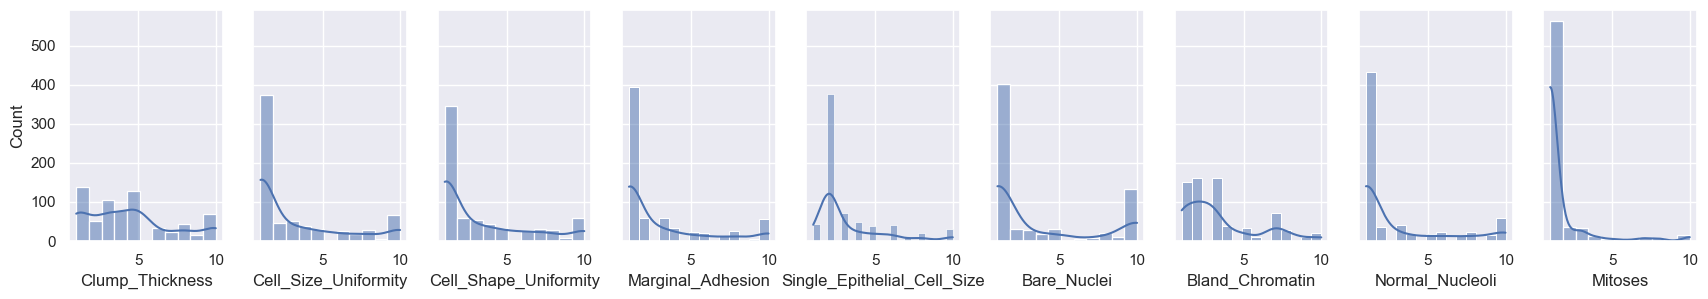

In [38]:
features = [x for x in data_null_treated.columns if x not in ['Class','Sample_number']]
fig, ax = plt.subplots(nrows=1, ncols=len(features),
                       figsize=(21,3),
                       sharey=True, sharex=True)

for col, (f) in enumerate(features):
    sns.histplot(data_null_treated[f],
                 ax=ax[col],
                 kde=True)

- All features range between 1 and 10, so probably no scaling required
- A lot of the features seem to be skewed towards 1. These features may have a more or less significant impact on class prediction, depending on how rare malignant tumours are.

**5. Visualize class weights**

35.0% of patients have malignant tumors


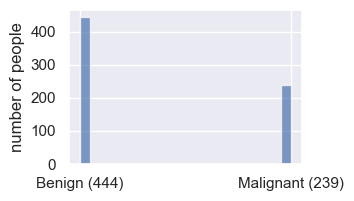

In [41]:
## Let's look at the distribution of targets ##
target = 'Class'
y = data_null_treated[[target]]

## Plot histogram ##
plt.figure(figsize=(3,2))
plt.hist(y, bins=20,alpha=0.7)

## Set axes ##
counts = y.value_counts()
plt.xticks([0,1],[f'{label} ({count})' for label,count in zip(['Benign','Malignant'], counts)])
plt.ylabel('number of people');

prop_donated = round((counts[1] / (counts[0]+counts[1])),3)
print(f'{prop_donated*100}% of patients have malignant tumors')

**6. Visualize statistical outliers**

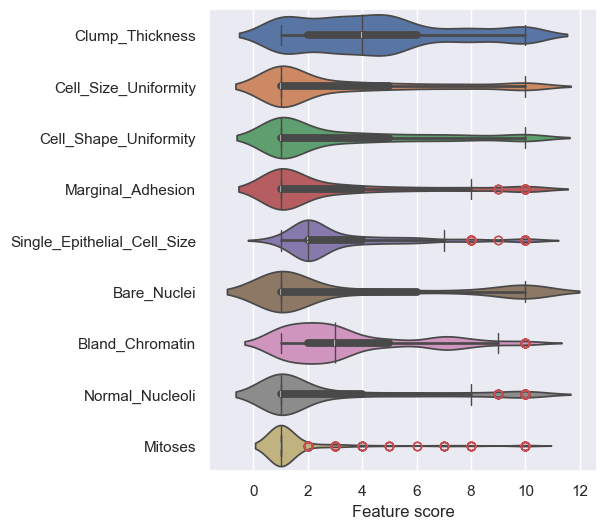

In [45]:
## Plot distributions of scaled features ##
sns.set()

## Set up subplots figure object to plot onto ##
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(5,6))

## First plot violin plot to see distributions ##
sns.violinplot(data_null_treated[features],
            orient='h',
            ax=ax)

## Next plot boxplots to get automatically calculated outliers (Tukey's method) ##
flierprops = dict(marker='o', markeredgecolor='r') # properties of outlier markers
sns.boxplot(data_null_treated[features],
            boxprops=dict(alpha=0), # set boxplot color to completely transparent, to only visualize violin plot
            flierprops=flierprops, #set properties of outlier markers
            orient='h',
            ax=ax)
plt.xlabel('Feature score');

- Of the features identified to have statistical outliers, what do their class distributions look like? Do these outliers actually differentiate between benign and malignant? If so, then we probably shouldn't remove these outliers

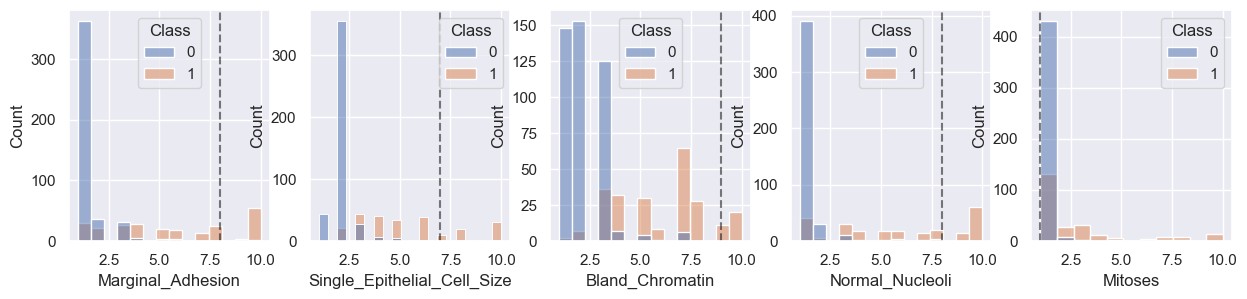

In [60]:
outlier_features = ['Marginal_Adhesion','Single_Epithelial_Cell_Size','Bland_Chromatin','Normal_Nucleoli','Mitoses']
outlier_values = [9, 8, 10, 9, 2]
fig, ax = plt.subplots(nrows=1, ncols=len(outlier_features),
                       figsize=(15,3))

for col, (f, v) in enumerate(zip(outlier_features, outlier_values)):
    sns.histplot(data_null_treated[[f]+['Class']],
                 x=f,
                 hue='Class',
                 ax=ax[col])
    ax[col].axvline(v-1, ls='--', color='black', alpha=0.5)

- Seems like for all features, these outlier values are always malignant tumor cases (except for mitoses) so these outliers are probably quite important to keep

**7. Feature engineering**

- Given how zero-padded a lot of these features are, and how most zero values are malignant cases, maybe these features could be engineered into a binary feature (i.e. 1 = low, > 1 = high), but I wouldn't do this without SME consultation.

# Implement model #

- Implement a binary classification model to predict benign or malignant tumours using numeric biomarker features
- Use a bagging classifier with decision tree base estimator

In [67]:
## Initialize defauly bagging classifier with no hyperparameter setting ##
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42)

# Step 6: Modelling
Refer to the Problem and Main Question.
- What are the input variables (features)?
- Is there an output variable (label)?
- If there is an output variable:
    - What is it?
    - What is its type?
- What type of Modelling is it?
    - [ ] Supervised
    - [ ] Unsupervised
- What type of Modelling is it?
    - [ ] Regression
    - [ ] Classification (binary)
    - [ ] Classification (multi-class)
    - [ ] Clustering

# Step 7: Split the Data

Need to check for **Supervised** modelling:
- Number of known cases or observations
- Define the split in Training/Test or Training/Validation/Test and their proportions
- Check for unbalanced classes and how to keep or avoid it when spliting

# Step 8: Define and Fit Models

Define the model and its hyper-parameters.

Consider the parameters and hyper-parameters of each model at each (re)run and after checking the efficiency of a model against the training and test datasets.

# Step 9: Verify and Evaluate the Training Model
- Use the **training** data to make predictions
- Check for overfitting
- What metrics are appropriate for the modelling approach used
- For **Supervised** models:
    - Check the **Training Results** with the **Training Predictions** during development
- Analyse, modify the parameters and hyper-parameters and repeat (within reason) until the model does not improve

# Step 10: Make Predictions and Evaluate the Test Model
**NOTE**: **Do this only after not making any more improvements in the model**.

- Use the **test** data to make predictions
- For **Supervised** models:
    - Check the **Test Results** with the **Test Predictions**

# Step 11: Solve the Problem or Answer the Question
The results of an analysis or modelling can be used:
- As part of a product or process, so the model can make predictions when new input data is available
- As part of a report including text and charts to help understand the problem
- As input for further questions



---



---



> > > > > > > > > Â© 2023 Institute of Data


---



---



